This is an test notebook for the audio data pipeline

In [74]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

0it [00:00, ?it/s]

0it [00:00, ?it/s]


(517, 513)


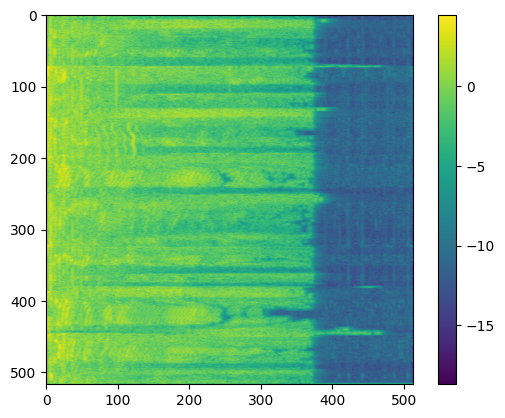

In [103]:
tracks = pd.read_csv('./data/processed_genres.csv')
channels = []
for idx, track in tqdm(tracks.iterrows()):
    fpath = './data/fma_medium' + track['fpath']
    dim = 44100*3
    audio = tfio.audio.AudioIOTensor(fpath)
    shape = audio.shape
    audio_slice = audio[:dim]

    if tf.equal(shape[-1], 2):
        audio_tensor = tf.reduce_mean(audio_slice, axis=[-1])
    else:
        audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    # if len(audio_tensor) > dim:
    #     audio_tensor = audio_tensor[:dim]
    # else:
    #     audio_tensor = tf.pad(audio_tensor, (0, dim-len(audio_tensor)), 'constant', constant_values=0)
    
    #print(audio_tensor)
    # Make a spectrogram
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=1024, window=512, stride=256)
    spectrogram = tf.math.log(spectrogram)

    non_infinite_mask = tf.math.is_finite(spectrogram)
    non_infinite_values = tf.boolean_mask(spectrogram, non_infinite_mask)

    # Calculate the mean of non-infinite values
    mean_non_infinite = tf.reduce_mean(non_infinite_values)

    # Replace infinite values with the mean
    spectrogram = tf.where(tf.math.is_inf(spectrogram), tf.fill(spectrogram.shape, mean_non_infinite), spectrogram)

    print(spectrogram.shape)
    plt.figure()
    plt.imshow(spectrogram)
    plt.colorbar()
    break

(32, 512, 512) (32,)


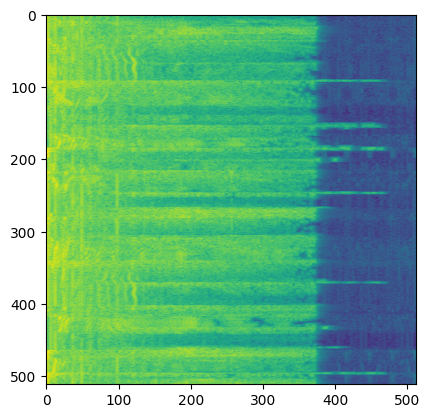

In [64]:
class DataGen():
    def __init__(self, df, sample_rate=44100, seconds=3, batch_size=32, shuffle=True):
        self.df = np.array(df)
        self.sample_rate = sample_rate
        self.seconds = seconds
        self.dim = self.sample_rate * self.seconds
        self.data_size = self.df.shape[0]
        self.indices = tf.range(0, self.data_size, delta=1)
        if shuffle:
            tf.random.shuffle(self.indices)
        self.batch_size = batch_size
    
    def __len__(self):
        return self.data_size//self.batch_size
    
    def get_sample(self, x):
        fpath = './data/fma_medium' + self.df[x][-1]
        audio = tfio.audio.AudioIOTensor(fpath)
        shape = audio.shape
        start_idx = tf.random.uniform(shape=[], minval=0, maxval=shape[0] - self.dim,
                                      dtype=tf.int64)
        audio_slice = audio[start_idx:start_idx + self.dim]
        # Convert to one channel
        # either by averaging stereo channels or removing extra dim on mono
        if tf.equal(shape[-1], 2):
            audio_tensor = tf.reduce_mean(audio_slice, axis=[-1])
        else:
            audio_tensor = tf.squeeze(audio_slice, axis=[-1])
        
        # Make a spectrogram and clip off values to get 512x512 image
        # Original image will be 517x513 so this doesn't affect much.
        spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=1024, window=512, stride=256)[:512, :512]
        spectrogram = tf.math.log(spectrogram)

        return spectrogram, self.df[x][1]
    
    def __call__(self):
        for idx in self.indices:
            yield self.get_sample(idx)

tracks = pd.read_csv('./data/processed_genres.csv')
train_gen = DataGen(tracks)
output_signature=(
  tf.TensorSpec(shape=(512, 512), dtype=tf.float32, name=None),
  tf.TensorSpec(shape=(), dtype=tf.int32, name=None))
batch_size = 32
train_data = tf.data.Dataset.from_generator(train_gen, output_signature=output_signature)
train_data = train_data.batch(batch_size)

(32, 512, 512) (32,)
Class: 0


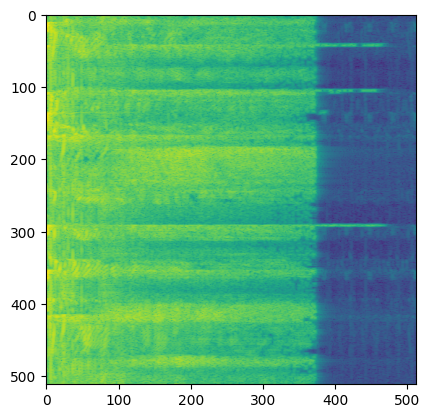

In [65]:
X, y = next(iter(train_data))
print(X.shape, y.shape)

plt.figure()
plt.imshow(X[0])
print(f"Class: {y[0]}")